In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
spark.sql("use data_vkapi")

2024-06-08 00:44:05,199 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


DataFrame[]

In [212]:
tables = spark.sql("show tables")
tables.show()

+----------+----------+-----------+
|  database| tableName|isTemporary|
+----------+----------+-----------+
|data_vkapi|post_likes|      false|
|data_vkapi|     posts|      false|
|data_vkapi|user_posts|      false|
|data_vkapi|     users|      false|
+----------+----------+-----------+



In [65]:
usersDF = spark.read.table("data_vkapi.users")
usersDF.show(5)

+-------+----------+----+------+-------+------------------+--------------------+---+--------+----------+---------+---------+
|user_id|     bdate| age|  city|country|last_seen_platform|      last_seen_time|sex|verified|first_name|last_name|is_closed|
+-------+----------+----+------+-------+------------------+--------------------+---+--------+----------+---------+---------+
| 303206|2000-09-16|null|Moscow| Russia|       Android app|2024-06-07 13:30:...|  M|       0|    Andrey| Rinchino|        1|
| 989742|2000-04-08|  34|Moscow| Russia|      Full version|2024-06-07 17:01:...|  F|       0|     Irina|    Lebed|        0|
|4510163|2000-11-18|null|Moscow| Russia|        iPhone app|2024-06-07 17:02:...|  F|       0|Printsessa|     Olga|        0|
|5763938|2000-06-22|  19|Moscow| Russia|       Android app|2024-06-07 17:13:...|  F|       0|      Anna|Solovyova|        0|
|8100016|2000-09-21|  30|Moscow| Russia|      Full version|2024-06-06 21:32:...|  F|       0|     Diana|Sarkisyan|        0|


In [129]:
postsDF = spark.read.table("data_vkapi.posts")
postsDF.show(5)

+-------+--------------------+-----+--------+-------+-----+-----------+--------+
|post_id|                date|likes|comments|reposts|views|attachments|text_len|
+-------+--------------------+-----+--------+-------+-----+-----------+--------+
|     10|2019-12-03 17:40:...|    3|       0|      0|  230|          0|     134|
|     11|2019-12-03 17:47:...|    3|       0|      0|  407|          0|     152|
|     15|2019-12-26 17:24:...|   17|       1|      0|  409|          1|      25|
|     26|2020-03-06 23:57:...|    2|       0|      0|  188|          1|      58|
|     39|2020-03-28 02:04:...|    2|       0|      0|  271|          0|       1|
+-------+--------------------+-----+--------+-------+-----+-----------+--------+
only showing top 5 rows



In [67]:
post_likesDF = spark.read.table("data_vkapi.post_likes")
post_likesDF.show(5)

+-------+---------+
|post_id|  user_id|
+-------+---------+
|    764| 56715320|
|    764|188563975|
|    764|229991524|
|    764|269074055|
|    758| 56715320|
+-------+---------+
only showing top 5 rows



In [68]:
user_postsDF = spark.read.table("data_vkapi.user_posts")
user_postsDF.show(5)

+-------+-------+--------------------+-----+--------+-------+-----+-----------+--------+
|user_id|post_id|           post_date|likes|comments|reposts|views|attachments|text_len|
+-------+-------+--------------------+-----+--------+-------+-----+-----------+--------+
|8100016|  12169|2022-05-27 03:04:...|   47|       0|      0| 1676|          1|      33|
|8100016|  12192|2024-06-01 15:33:...|    0|       0|      0|  139|          0|       3|
|8100016|  12191|2023-10-13 03:26:...|   93|       0|      1|  482|          1|       1|
|8100016|  12190|2023-09-22 04:41:...|   73|       0|      0|  761|          3|      39|
|8100016|  12189|2023-09-18 05:51:...|   84|       0|      0|  884|          1|       6|
+-------+-------+--------------------+-----+--------+-------+-----+-----------+--------+
only showing top 5 rows



Text(0, 0.5, '')

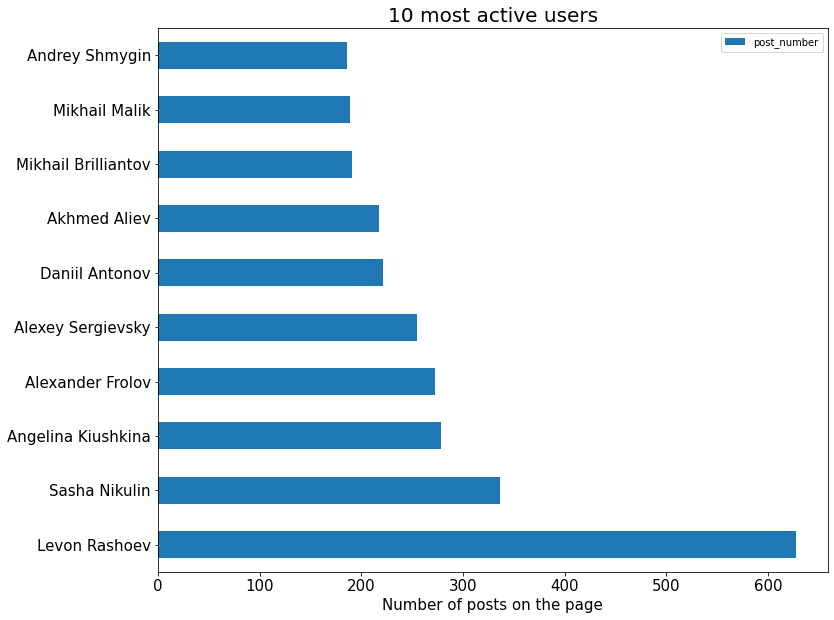

In [348]:
# find 10 most active users. Activity is defined by the amount of posts on the page
# from pyspark.sql.functions import col

# user_posts_amount = user_postsDF \
#     .groupBy('user_id') \
#     .count()

# usersDF_amount = usersDF \
#     .join(user_posts_amount, user_posts_amount.user_id == usersDF.user_id, "left") \
#     .withColumnRenamed("count", "posts_number") \
#     .na.fill(value=0,subset=["posts_number"]) \
#     .orderBy(col("posts_number").desc())


# users_info = usersDF_amount.toPandas()

# top10 = users_info.sort_values('posts_number', ascending=False).head(10)
# top10['FI'] = top10[['first_name', 'last_name']].apply(lambda x: ' '.join(x), axis=1)

# top10.plot.bar(x='first_name', y='posts_number', figsize=(12, 10))

# find 10 most active users. Activity is defined by the amount of posts on the page
users = usersDF.toPandas()
user_posts = user_postsDF.toPandas()

posts_amount = user_posts.groupby('user_id').size().reset_index().rename(columns={0:'post_number'})

users_info = users.merge(posts_amount, on='user_id', how='left')
top10 = users_info.sort_values('post_number', ascending=False).head(10)
top10['FI'] = top10[['first_name', 'last_name']].apply(lambda x: ' '.join(x), axis=1)

ax = top10.plot.barh(x='FI', y='post_number', figsize=(12, 10))
ax.set_title("10 most active users", fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xlabel('Number of posts on the page', fontsize=15)
ax.set_ylabel('', fontsize=15)


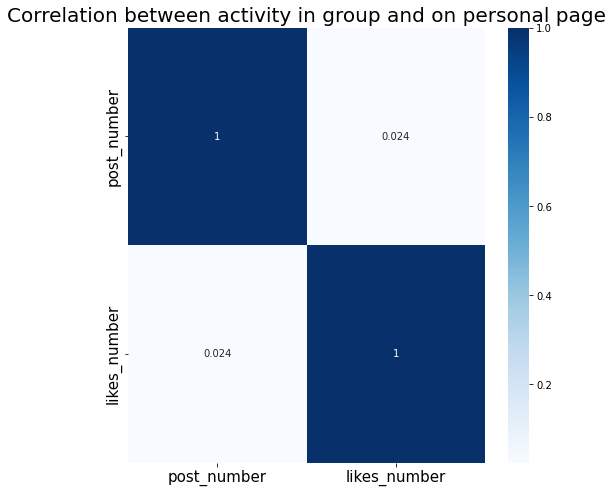

In [350]:
# correlation between activity on page and amount of likes in group 

# user_likes_group = post_likesDF.groupBy('user_id') \
#     .count() \
#     .withColumnRenamed("count", "likes_in_group")

# usersDF_wlikes = usersDF_amount \
#     .join(user_likes_group, usersDF_amount["spark_catalog.data_vkapi.users.user_id"] == user_likes_group.user_id, "left") \
#     .na.fill(value=0, subset=["likes_in_group"])

# correlation = usersDF_wlikes.stat.corr('posts_number', 'likes_in_group')

# print(f"The correlation between 'col1' and 'col2' is: {correlation}")



# correlation between activity on page and amount of likes in group 
post_likes = post_likesDF.toPandas()

likes = post_likes.groupby('user_id').size().reset_index().rename(columns={0:'likes_number'})
likes
users_info_all = users_info.merge(likes, on='user_id', how='left')

info_filtered = users_info_all[users_info_all[['post_number', 'likes_number']].notnull().all(1)]


import seaborn as sns

plt.figure(figsize=(8, 8))
ax = sns.heatmap(info_filtered.iloc[:, -2:].corr(), annot=True, cmap='Blues')
ax.set_title("Correlation between activity in group and on personal page", fontsize=20)
ax.tick_params(labelsize=15)
plt.show()


In [254]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
     |████████████████████████████████| 34.5 MB 15 kB/s  eta 0:00:01 MB 1.4 MB/s eta 0:00:239 MB 1.4 MB/s eta 0:00:17:00:07MB/s eta 0:00:07                  | 13.5 MB 3.5 MB/s eta 0:00:07�███████▏               | 17.5 MB 3.5 MB/s eta 0:00:05�███████████▌             | 20.0 MB 3.5 MB/s eta 0:00:05B 3.5 MB/s eta 0:00:04�           | 22.3 MB 3.5 MB/s eta 0:00:04█████████████▋        | 25.4 MB 1.1 MB/s eta 0:00:09�███████████▋       | 26.6 MB 1.1 MB/s eta 0:00:08     |█████████████████████████▍      | 27.5 MB 1.1 MB/s eta 0:00:07��█████████████████▉      | 27.8 MB 1.1 MB/s eta 0:00:06��████████████████████    | 30.2 MB 1.1 MB/s eta 0:00:04��█████████████████████████▊  | 32.1 MB 1.1 MB/s eta 0:00:03     |█████████████████████████████▉  | 32.2 MB 1.1 MB/s e

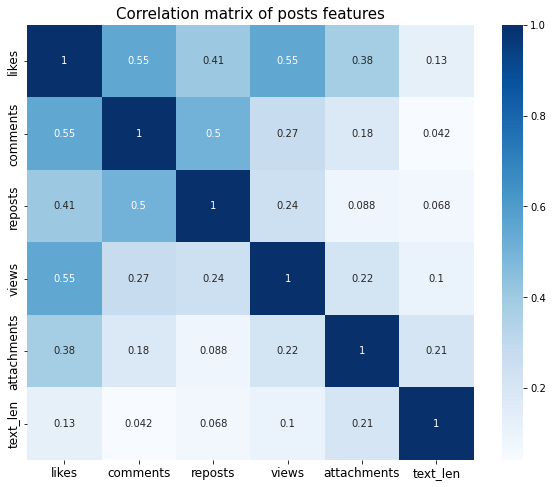

In [327]:
# correlation between length length of posts and likes, comments and views
# from pyspark.ml.stat import Correlation
# from pyspark.ml.feature import VectorAssembler
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# postsDF_ = postsDF.drop('date').drop("post_id")

# vector_col = 'corr_features'
# assembler = VectorAssembler(inputCols=postsDF_.columns, outputCol=vector_col)
# df_vector = assembler.transform(postsDF_).select(vector_col)

# #calculate correlation matrix
# corr_matrix = Correlation.corr(df_vector, vector_col)

# #display correlation matrix
# corr = corr_matrix.collect()[0]['pearson({})'.format(vector_col)].values

# corr_df = pd.DataFrame(corr.reshape(len(postsDF_.columns), len(postsDF_.columns)),
#                        columns=postsDF_.columns, index=postsDF_.columns)

# # Create the heatmap
# plt.figure(figsize=(15, 9))
# sns.heatmap(corr_df, annot=True, cmap='coolwarm', square=True)
# plt.show()



# correlation between length length of posts and likes, comments and views
posts = postsDF.toPandas()

posts_data = posts.loc[:, ~posts.columns.isin(['date'])].set_index('post_id')
corr_df = posts_data.corr()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_df, annot=True, cmap='Blues')
ax.tick_params(labelsize=12)
ax.set_title("Correlation matrix of posts features", fontsize=15)
plt.show()

In [253]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
     |███████████████████▌            | 21.1 MB 3.6 MB/s eta 0:00:04          | 7.0 MB 1.2 MB/s eta 0:00:23 | 8.9 MB 1.2 MB/s eta 0:00:22                  | 9.7 MB 1.2 MB/s eta 0:00:21 MB 1.2 MB/s eta 0:00:20��█████                     | 11.8 MB 3.6 MB/s eta 0:00:07          | 15.7 MB 3.6 MB/s eta 0:00:06█████▏                | 16.3 MB 3.6 MB/s eta 0:00:06�███████▏               | 17.5 MB 3.6 MB/s eta 0:00:05ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/usr/local/lib/python3.8/site-packages/pip/_vendor/urllib3/response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib

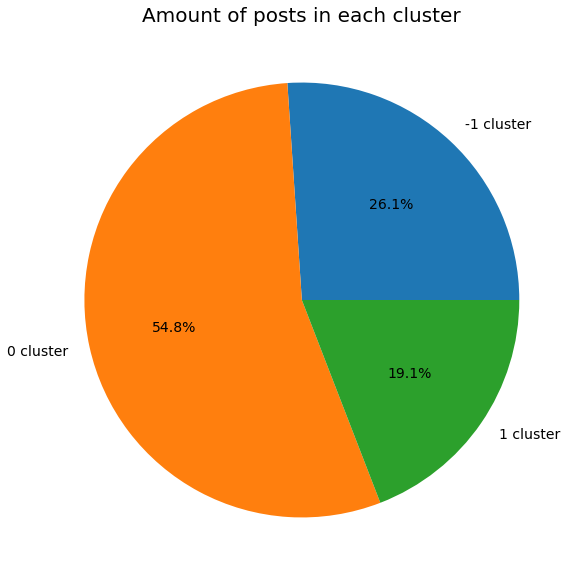

In [343]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import numpy as np

scaler = MinMaxScaler()
norm_data = pd.DataFrame(scaler.fit_transform(posts_data),columns= posts_data.columns) # нормализованные данные

DBScan = DBSCAN(eps=0.1, min_samples=20, metric='l1')
DB = DBScan.fit_predict(norm_data)

unique, counts = np.unique(DB, return_counts=True)

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(counts, labels=['-1 cluster', '0 cluster', '1 cluster'], autopct='%1.1f%%', textprops={'fontsize':14})
ax.set_title("Amount of posts in each cluster", fontsize=20)
plt.show()

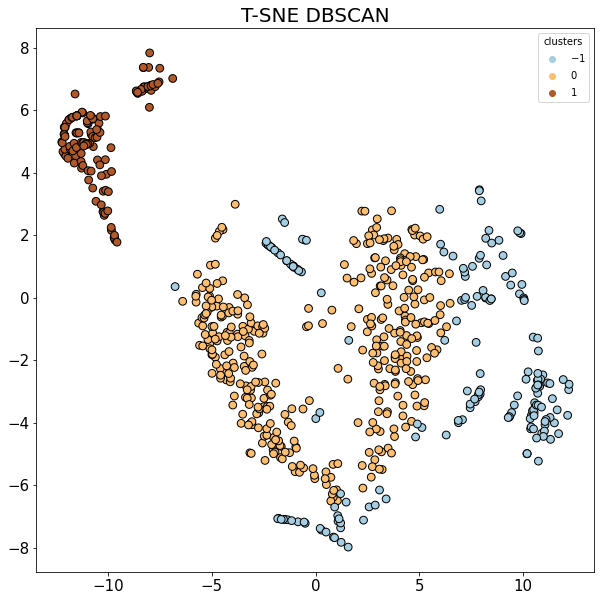

In [364]:
# T-SNE visualisation
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=130, random_state=101).fit_transform(norm_data)

fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=60,
           c=DB, marker='o', cmap = 'Paired', edgecolors='black')
ax.set_title("T-SNE DBSCAN", fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(*scatter.legend_elements(), title='clusters')
plt.show()

In [268]:
posts_data['cluster'] = DB

Text(0.5, 1.0, 'Likes distribution in cluster')

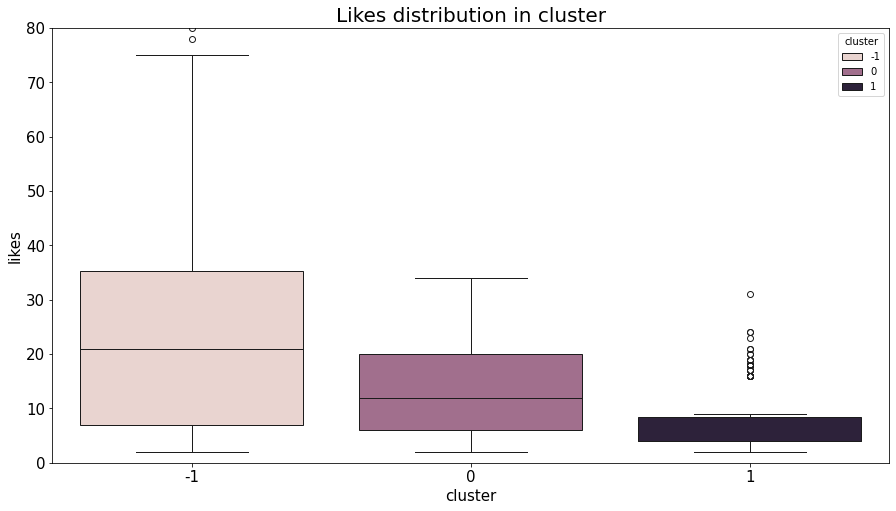

In [302]:
plt.figure(figsize=(15,8)) 
ax = sns.boxplot(data=posts_data, x='cluster', y='likes', hue='cluster')
ax.tick_params(labelsize=15)
ax.set_xlabel('cluster', fontsize=15)
ax.set_ylabel('likes', fontsize=15)
ax.set_ylim([0, 80])
ax.set_title("Likes distribution in cluster", fontsize=20)

(0.0, 20.0)

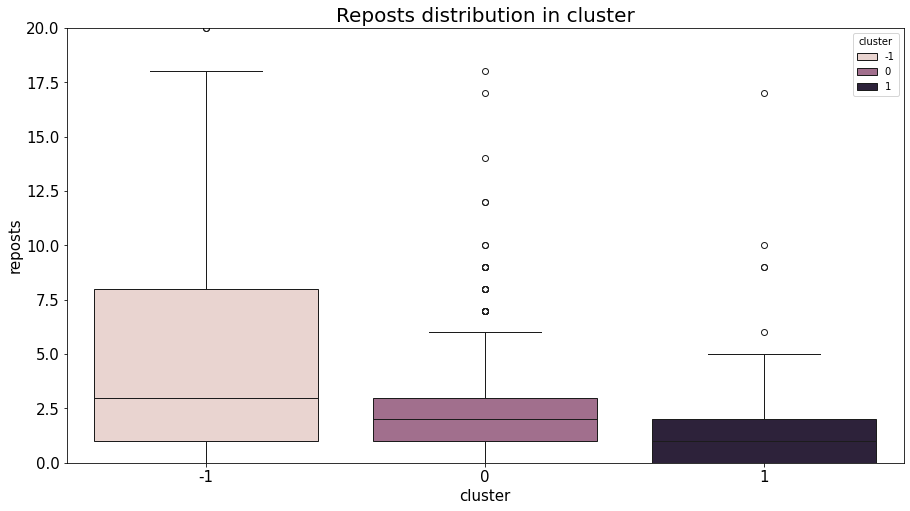

In [307]:
plt.figure(figsize=(15,8)) 
ax = sns.boxplot(data=posts_data, x='cluster', y='reposts', hue='cluster')
ax.tick_params(labelsize=15)
ax.set_xlabel('cluster', fontsize=15)
ax.set_ylabel('reposts', fontsize=15)
ax.set_title("Reposts distribution in cluster", fontsize=20)
ax.set_ylim([0, 20])

(0.0, 2500.0)

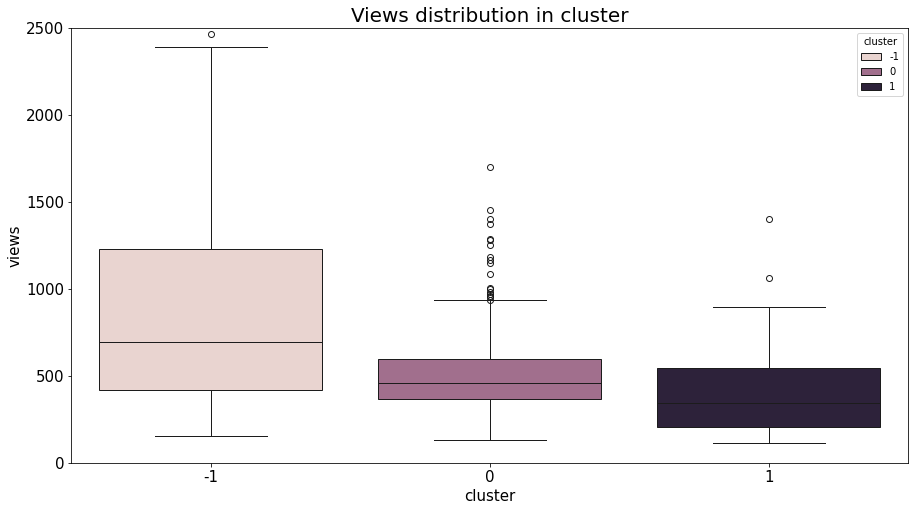

In [308]:
plt.figure(figsize=(15,8)) 
ax = sns.boxplot(data=posts_data, x='cluster', y='views', hue='cluster')
ax.tick_params(labelsize=15)
ax.set_xlabel('cluster', fontsize=15)
ax.set_ylabel('views', fontsize=15)
ax.set_title("Views distribution in cluster", fontsize=20)
ax.set_ylim([0, 2500])

(0.0, 10.0)

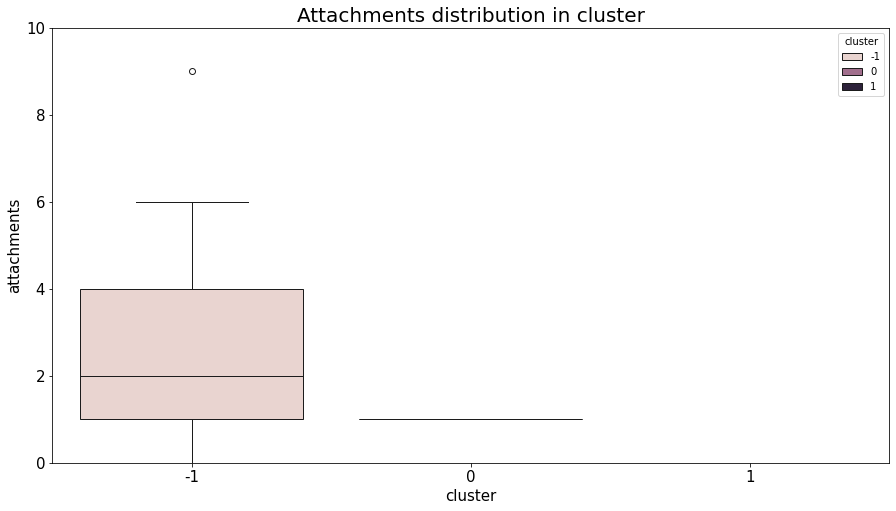

In [309]:
plt.figure(figsize=(15,8)) 
ax = sns.boxplot(data=posts_data, x='cluster', y='attachments', hue='cluster')
ax.tick_params(labelsize=15)
ax.set_xlabel('cluster', fontsize=15)
ax.set_ylabel('attachments', fontsize=15)
ax.set_title("Attachments distribution in cluster", fontsize=20)
ax.set_ylim([0, 10])

(0.0, 300.0)

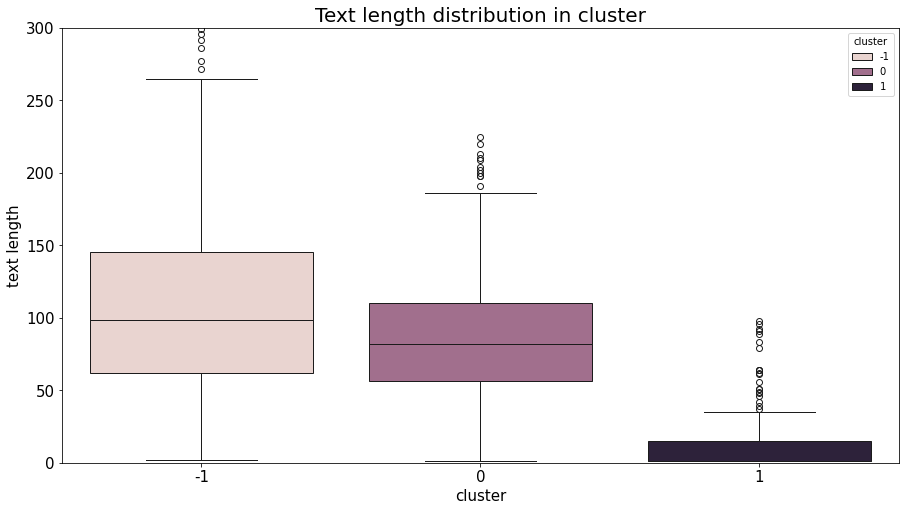

In [311]:
plt.figure(figsize=(15,8)) 
ax = sns.boxplot(data=posts_data, x='cluster', y='text_len', hue='cluster')
ax.tick_params(labelsize=15)
ax.set_xlabel('cluster', fontsize=15)
ax.set_ylabel('text length', fontsize=15)
ax.set_title("Text length distribution in cluster", fontsize=20)
ax.set_ylim([0, 300])

In [274]:
posts_data[posts_data['cluster'] == -1].describe()

,likes,comments,reposts,views,attachments,text_len,cluster
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.0
mean,24.684783,1.005435,7.891304,1393.032609,2.320652,116.282609,-1.0
std,21.560908,2.401041,26.718306,2425.601988,1.606138,80.674591,0.0
min,2.000000,0.000000,0.000000,152.000000,0.000000,2.000000,-1.0
25%,7.000000,0.000000,1.000000,416.750000,1.000000,61.750000,-1.0
50%,21.000000,0.000000,3.000000,693.500000,2.000000,98.500000,-1.0
75%,35.250000,1.000000,8.000000,1231.000000,4.000000,145.500000,-1.0
max,116.000000,16.000000,351.000000,17740.000000,9.000000,630.000000,-1.0


In [275]:
posts_data[posts_data['cluster'] == 0].describe()

,likes,comments,reposts,views,attachments,text_len,cluster
count,387.000000,387.000000,387.000000,387.000000,387.0,387.000000,387.0
mean,13.356589,0.069767,2.516796,505.180879,1.0,87.377261,0.0
std,8.067846,0.255084,2.624437,224.220234,0.0,42.725989,0.0
min,2.000000,0.000000,0.000000,130.000000,1.0,1.000000,0.0
25%,6.000000,0.000000,1.000000,367.500000,1.0,56.500000,0.0
50%,12.000000,0.000000,2.000000,460.000000,1.0,82.000000,0.0
75%,20.000000,0.000000,3.000000,595.500000,1.0,110.000000,0.0
max,34.000000,1.000000,26.000000,1701.000000,1.0,225.000000,0.0


In [276]:
posts_data[posts_data['cluster'] == 1].describe()

,likes,comments,reposts,views,attachments,text_len,cluster
count,135.000000,135.000000,135.000000,135.000000,135.0,135.000000,135.0
mean,7.807407,0.051852,1.555556,397.703704,0.0,14.259259,1.0
std,6.430450,0.253881,2.790353,229.917898,0.0,24.284988,0.0
min,2.000000,0.000000,0.000000,112.000000,0.0,1.000000,1.0
25%,4.000000,0.000000,0.000000,203.500000,0.0,1.000000,1.0
50%,4.000000,0.000000,1.000000,345.000000,0.0,1.000000,1.0
75%,8.500000,0.000000,2.000000,543.000000,0.0,15.000000,1.0
max,31.000000,2.000000,21.000000,1404.000000,0.0,98.000000,1.0


In [192]:
# post clusreting
from pyspark.ml.feature import VectorAssembler 
  
vec_assembler = VectorAssembler(inputCols = postsDF_.columns, 
                                outputCol='features') 
  
final_data = vec_assembler.transform(postsDF_) 
final_data.select('features').show(5)


+--------------------+
|            features|
+--------------------+
|[3.0,0.0,0.0,230....|
|[3.0,0.0,0.0,407....|
|[17.0,1.0,0.0,409...|
|[2.0,0.0,0.0,188....|
|[2.0,0.0,0.0,271....|
+--------------------+
only showing top 5 rows



In [199]:
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator 
  
evaluator = ClusteringEvaluator()

kmeans=KMeans(k=3) 
model=kmeans.fit(final_data) 
predictions=model.transform(final_data)

In [200]:
score=evaluator.evaluate(predictions) 
print(f'silhouette: {score}')

silhouette: 0.9822719680899131


In [201]:
centers = model.clusterCenters()
print("Cluster Centers: ") 
for center in centers: 
    print(center)

Cluster Centers: 
[1.43623188e+01 2.72463768e-01 2.96521739e+00 5.55676812e+02
 1.12753623e+00 8.03289855e+01]
[1.00666667e+02 3.66666667e+00 1.80000000e+01 1.68740000e+04
 2.66666667e+00 9.13333333e+01]
[4.25384615e+01 1.53846154e+00 4.12307692e+01 5.49800000e+03
 2.15384615e+00 1.10384615e+02]


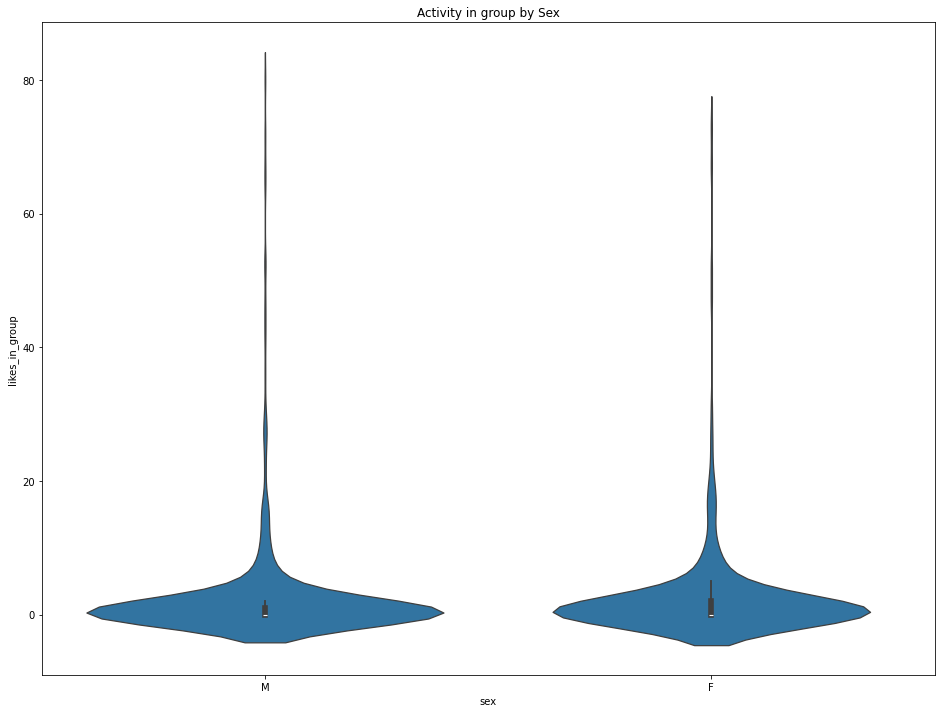

In [210]:
# activity in group by sex 
usersDF_wlikes_ = usersDF_wlikes.toPandas()
usersDF_wlikes_ = usersDF_wlikes_[usersDF_wlikes_['likes_in_group'] < 100]

plt.figure(figsize=(16, 12))
sns.violinplot(x="sex", y="likes_in_group", data=usersDF_wlikes_)
plt.title("Activity in group by Sex")
plt.show()

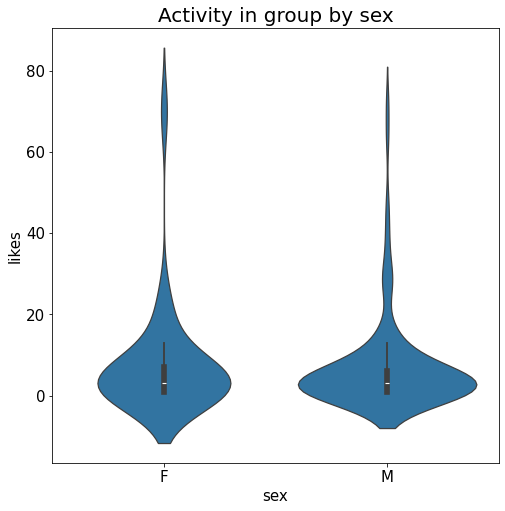

In [342]:
# activity in group by sex

plt.figure(figsize=(8, 8))
ax = sns.violinplot(x='sex', y='likes_number', data=info_filtered[info_filtered['likes_number'] < 100])
ax.set_xlabel('sex', fontsize=15)
ax.set_ylabel('likes', fontsize=15)
ax.tick_params(labelsize=15)
ax.set_title("Activity in group by sex", fontsize=20)
plt.show()

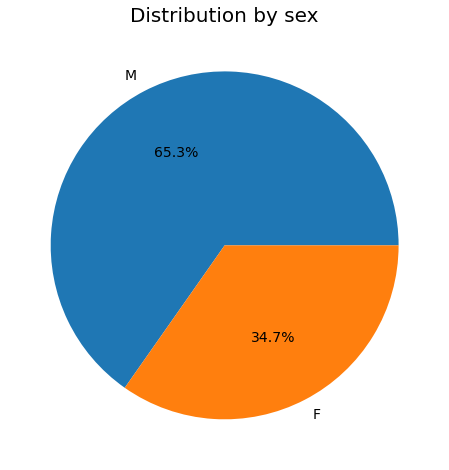

In [334]:
# sex distribution
sex = usersDF_wlikes \
    .select('sex') \
    .rdd \
    .flatMap(lambda x: x) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .collect()

labels = [i[0] for i in sex]
amounts = [i[1] for i in sex]


fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(amounts, labels=labels, autopct='%1.1f%%', textprops={'fontsize':14})
ax.set_title("Distribution by sex", fontsize=20)
plt.show()